# Data Overview

- from_date	: Tanggal dan jam mulai pencatatan data kualitas udara (datetime).
- to_date	: Tanggal dan jam akhir pencatatan data (biasanya 1 jam setelah from_date).
- pm2_5	: Partikulat udara halus (≤2.5 μm), berbahaya bagi kesehatan pernapasan.
- pm10	: Partikulat udara kasar (≤10 μm), umum berasal dari debu jalan atau konstruksi.
- no : Nitric oxide (NO), gas buangan dari kendaraan dan pembakaran.
- no2	: Nitrogen dioxide (NO₂), gas polutan beracun.
- nox	: Total senyawa nitrogen oksida (NO + NO₂), indikator emisi kendaraan.
- nh3	: Amonia (NH₃), biasanya berasal dari proses biologis dan industri.
- so2	: Sulfur dioxide (SO₂), berasal dari pembakaran bahan bakar fosil.
- co	: Karbon monoksida (CO), gas beracun dari pembakaran tidak sempurna.
- ozone	: Ozon (O₃), lapisan atmosfer rendah yang bisa menjadi polutan berbahaya.
- benzene	: Senyawa organik volatil, beracun, sering ditemukan di udara kota.
- toluene	: Senyawa organik volatil dari pelarut industri, dapat memengaruhi sistem saraf.
- eth_benzene	: Etilbenzena, VOC dari bahan bakar atau pelarut.
- mp_xylene	: Meta-para-xylene, salah satu bentuk senyawa xylene, berasal dari bahan bakar.
- temperature	: Suhu udara dalam derajat Celsius (tidak digunakan lebih lanjut karena duplikat ambient_temp).
- humidity	: Kelembapan udara relatif (%), memengaruhi kenyamanan dan polusi sekunder.
- wind_speed	: Kecepatan angin (m/s), penting untuk penyebaran polutan.
- wind_direction	: Arah angin (derajat), menunjukkan arah asal angin.
- solar_radiation	: Radiasi matahari (W/m²), bisa memengaruhi pembentukan ozon dan suhu.
- pressure	: Tekanan atmosfer (mmHg), bisa memengaruhi penyebaran udara polutan.
- vertical_wind_speed	: Kecepatan angin vertikal, pengaruh pada sirkulasi udara vertikal.
- ambient_temp	: Temperatur udara aktual yang jadi target prediksi (AT).
- rainfall	: Curah hujan (mm), dapat menurunkan polutan di udara.
- xylene	: Gabungan ortho-xylene dan isomer lainnya; VOC yang umum dari emisi kendaraan.

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [2]:
df = pd.read_csv('AP004.csv')

In [3]:
df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-09-05 14:00:00,2017-09-05 15:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,...,30.30,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
1,2017-09-05 15:00:00,2017-09-05 16:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,...,30.00,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2,2017-09-05 16:00:00,2017-09-05 17:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,...,29.85,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
3,2017-09-05 17:00:00,2017-09-05 18:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,...,29.25,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
4,2017-09-05 18:00:00,2017-09-05 19:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,...,28.05,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17


In [4]:
df.shape

(48802, 25)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   From Date            48802 non-null  object 
 1   To Date              48802 non-null  object 
 2   PM2.5 (ug/m3)        46344 non-null  float64
 3   PM10 (ug/m3)         46917 non-null  float64
 4   NO (ug/m3)           47244 non-null  float64
 5   NO2 (ug/m3)          47224 non-null  float64
 6   NOx (ppb)            46628 non-null  float64
 7   NH3 (ug/m3)          47140 non-null  float64
 8   SO2 (ug/m3)          46649 non-null  float64
 9   CO (mg/m3)           46387 non-null  float64
 10  Ozone (ug/m3)        47156 non-null  float64
 11  Benzene (ug/m3)      46914 non-null  float64
 12  Toluene (ug/m3)      46908 non-null  float64
 13  Eth-Benzene (ug/m3)  23988 non-null  float64
 14  MP-Xylene (ug/m3)    39256 non-null  float64
 15  Temp (degree C)      21599 non-null 

In [6]:
df.isna().sum()

From Date                  0
To Date                    0
PM2.5 (ug/m3)           2458
PM10 (ug/m3)            1885
NO (ug/m3)              1558
NO2 (ug/m3)             1578
NOx (ppb)               2174
NH3 (ug/m3)             1662
SO2 (ug/m3)             2153
CO (mg/m3)              2415
Ozone (ug/m3)           1646
Benzene (ug/m3)         1888
Toluene (ug/m3)         1894
Eth-Benzene (ug/m3)    24814
MP-Xylene (ug/m3)       9546
Temp (degree C)        27203
RH (%)                  1438
WS (m/s)                1427
WD (degree)             1429
SR (W/mt2)              1656
BP (mmHg)               1429
VWS (m/s)               1626
AT (degree C)           1516
RF (mm)                 1292
Xylene (ug/m3)          1727
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

# Prepare Column & Variable

In [8]:
df.rename(columns={
    "From Date": "from_date",
    "To Date": "to_date",
    "PM2.5 (ug/m3)": "pm2_5",
    "PM10 (ug/m3)": "pm10",
    "NO (ug/m3)": "no",
    "NO2 (ug/m3)": "no2",
    "NOx (ppb)": "nox",
    "NH3 (ug/m3)": "nh3",
    "SO2 (ug/m3)": "so2",
    "CO (mg/m3)": "co",
    "Ozone (ug/m3)": "ozone",
    "Benzene (ug/m3)": "benzene",
    "Toluene (ug/m3)": "toluene",
    "Eth-Benzene (ug/m3)": "eth_benzene",
    "MP-Xylene (ug/m3)": "mp_xylene",
    "Temp (degree C)": "temperature",
    "RH (%)": "humidity",
    "WS (m/s)": "wind_speed",
    "WD (degree)": "wind_direction",
    "SR (W/mt2)": "solar_radiation",
    "BP (mmHg)": "pressure",
    "VWS (m/s)": "vertical_wind_speed",
    "AT (degree C)": "ambient_temp",
    "RF (mm)": "rainfall",
    "Xylene (ug/m3)": "xylene"
}, inplace=True)

In [9]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# EDA

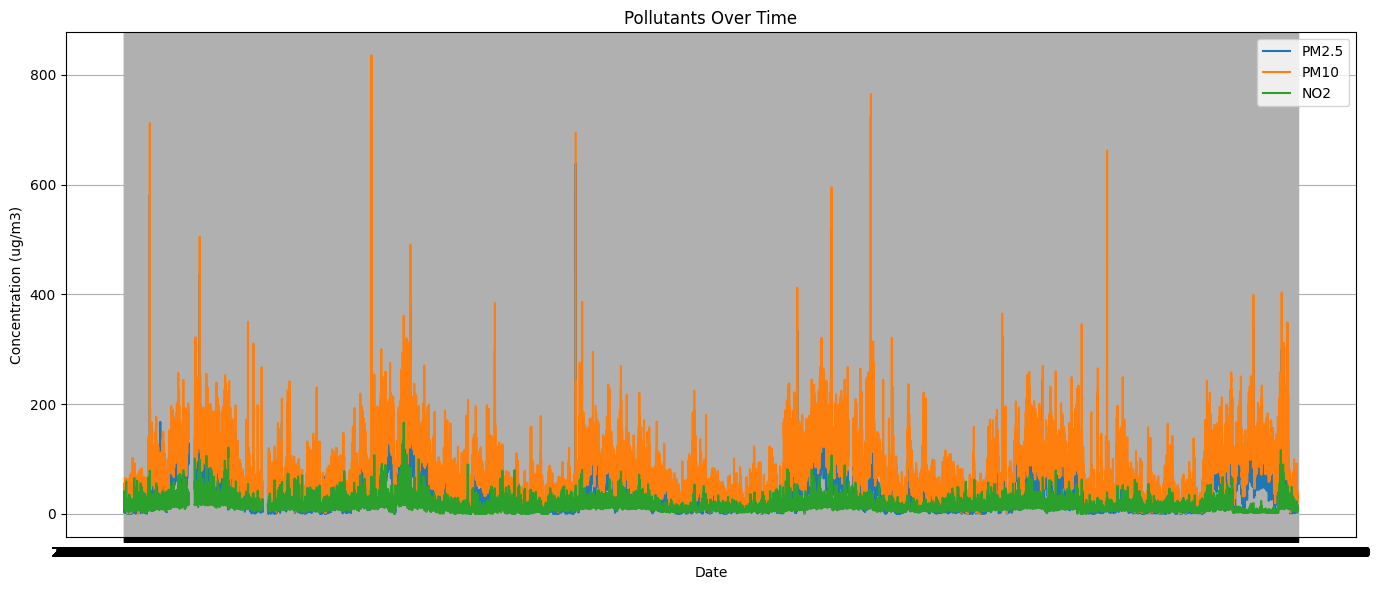

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df['from_date'], df['pm2_5'], label='PM2.5')
plt.plot(df['from_date'], df['pm10'], label='PM10')
plt.plot(df['from_date'], df['no2'], label='NO2')
plt.xlabel('Date')
plt.ylabel('Concentration (ug/m3)')
plt.title('Pollutants Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


PM10 adalah kontributor polusi utama dalam dataset ini
terdapat banyak lonjakan tajam (spike) pada nilai PM10 menandakan terjadinya event polusi besar. Ini bisa berarti:
- Aktivitas industri
- Kebakaran hutan
- Polusi debu atau partikel besar

PM2.5 dan NO2 terlihat lebih stabil dengan sedikit fluktuasi dan jauh lebih rendah skalanya.

Alasan mengapa perlu mengetahui informasi ini :
- PM2.5 dan PM10 adalah polutan yang paling berbahaya karena bisa masuk ke saluran pernapasan dan darah.
Melihat grafik ini membantu kita menilai potensi paparan masyarakat terhadap polutan berbahaya.
- Dari visual ini kita bisa melihat apakah tingkat polusi menurun atau meningkat dari waktu ke waktu.
Juga dapat digunakan untuk mendeteksi tren musiman, seperti meningkatnya polusi saat musim kemarau.

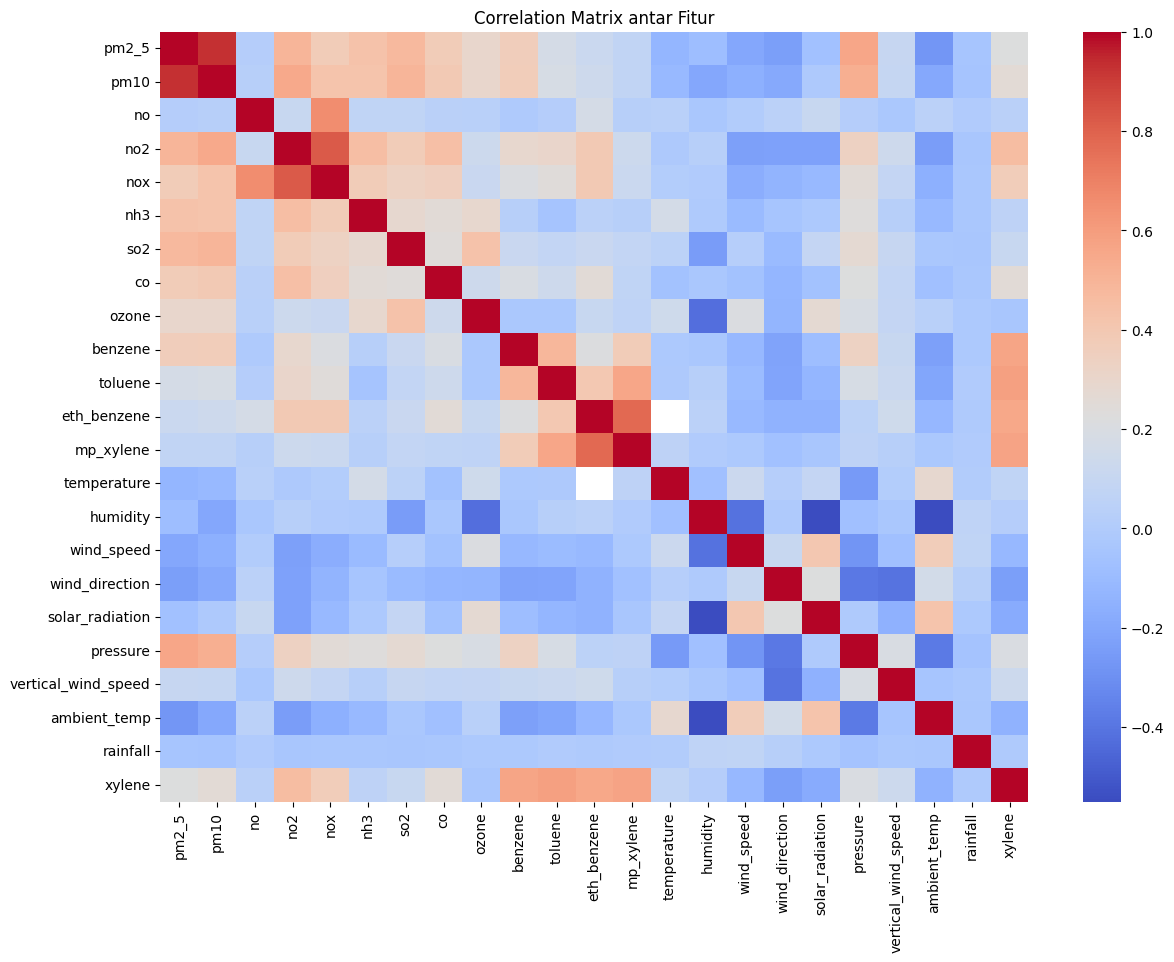

In [11]:
plt.figure(figsize=(14, 10))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix antar Fitur")
plt.show()

Hubungan Kuat antar Polutan
- PM2.5 dan PM10 menunjukkan korelasi positif kuat (mendekati 1). Artinya, ketika PM2.5 naik, PM10 cenderung ikut naik.
- NO, NO₂, dan NOx juga saling berkorelasi positif kuat. Ini wajar karena NOx (nitrogen oksida total) adalah gabungan dari NO dan NO₂.
- Benzene, toluene, eth_benzene, xylene, mp_xylene saling berkorelasi positif tinggi. Ini umum karena semua adalah senyawa organik volatil (VOC) dari sumber serupa, seperti emisi kendaraan atau industri.

Mengapa ini penting :
- Untuk menghindari redundansi dalam model prediktif karena fitur yang sangat berkorelasi seperti PM2.5–PM10 atau NO–NO₂–NOx dapat saling menggantikan. 
- Sementara itu, fitur dengan korelasi lemah seperti tekanan atau arah angin dapat diabaikan karena tidak berkontribusi signifikan dalam prediksi, kecuali ditemukan hubungan non-linear. 
- Selain itu, kelompok gas beracun seperti benzene, toluene, dan xylene yang berkorelasi tinggi bisa direduksi atau diproses bersama untuk menyederhanakan model tanpa kehilangan informasi penting.

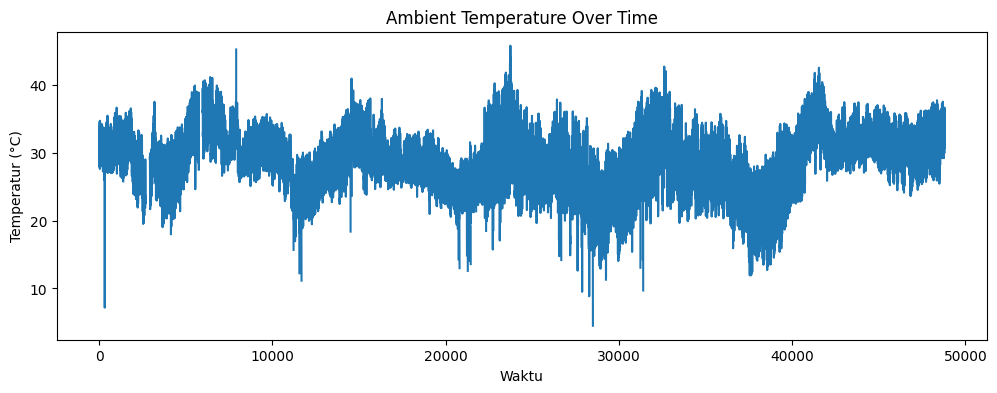

In [12]:
df['ambient_temp'].plot(figsize=(12, 4), title='Ambient Temperature Over Time')
plt.xlabel("Waktu")
plt.ylabel("Temperatur (°C)")
plt.show()


Plot ini menunjukkan fluktuasi suhu lingkungan (ambient_temp) sepanjang waktu. Terlihat bahwa suhu berfluktuasi secara periodik, kemungkinan mencerminkan pola musiman atau harian, dengan nilai rata-rata berada di kisaran 25–35°C, dan beberapa anomali ekstrem di bawah 10°C dan di atas 40°C.

Mengapa ini penting:
- Untuk mengetahui pola suhu lingkungan penting karena suhu dapat mempengaruhi reaksi kimia atmosfer, seperti pembentukan ozon dan degradasi polutan lain, serta membantu mengidentifikasi musim atau waktu tertentu dengan risiko polusi lebih tinggi. Selain itu, fluktuasi dan lonjakan suhu juga berguna untuk mendeteksi outlier atau kesalahan sensor yang perlu dibersihkan sebelum analisis lebih lanjut atau modeling dilakukan.

C:\Users\win10\AppData\Local\Temp\ipykernel_11056\3986260355.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Pollutant', y='Concentration', data=df_melted, palette='Set2')


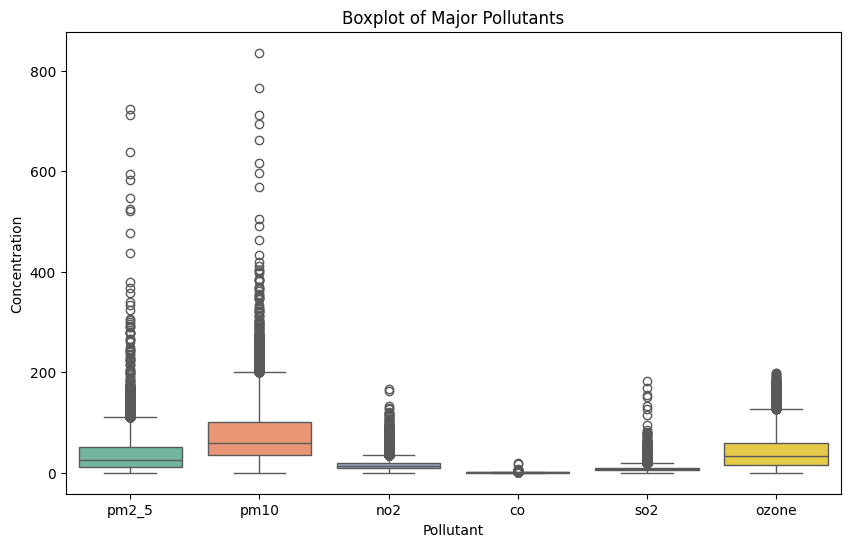

In [13]:
pollutants = ['pm2_5', 'pm10', 'no2', 'co', 'so2', 'ozone']
df_melted = df[pollutants].melt(var_name='Pollutant', value_name='Concentration')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Pollutant', y='Concentration', data=df_melted, palette='Set2')
plt.title('Boxplot of Major Pollutants')
plt.show()


Plot ini memperlihatkan persebaran konsentrasi beberapa polutan utama (pm2_5, pm10, no2, co, so2, dan ozone) menggunakan boxplot. Terlihat bahwa PM2.5 dan PM10 memiliki median yang lebih tinggi dan menyebar luas dengan banyak outlier ekstrem, menunjukkan bahwa kedua polutan ini paling bervariasi dan sering mengalami lonjakan tinggi. Sebaliknya, CO dan SO2 cenderung stabil dengan sebaran yang lebih sempit, sedangkan ozone memiliki nilai median yang cukup tinggi namun lebih konsisten.

Mengapa Ini Penting?
- Boxplot ini penting untuk mengidentifikasi sebaran, outlier, dan variabilitas dari masing-masing polutan, yang membantu memahami mana polutan yang perlu diawasi lebih ketat. Informasi ini berguna untuk penentuan prioritas pengendalian polusi, pembersihan data outlier, dan untuk membantu pemodelan prediktif agar lebih akurat dan tidak bias oleh nilai ekstrem.

In [14]:
for col in num_cols:
    stat, p = shapiro(df[col].dropna())
    print(f"{col}:")
    print(f"  p-value = {p}")

pm2_5:
  p-value = 2.1092996602614624e-109
pm10:
  p-value = 1.2119192987985764e-93
no:
  p-value = 1.3469289580563494e-156
no2:
  p-value = 2.8344349581280113e-108
nox:
  p-value = 5.838665440909054e-127
nh3:
  p-value = 3.17155637872578e-97
so2:
  p-value = 1.8343041395443314e-117
co:
  p-value = 9.951932840277158e-111
ozone:
  p-value = 7.240924724383841e-94
benzene:
  p-value = 1.871639870377872e-137
toluene:
  p-value = 2.0016211329332573e-142
eth_benzene:
  p-value = 6.730144705074378e-129
mp_xylene:
  p-value = 1.808338300692641e-153
temperature:
  p-value = 1.4402772133372696e-89
humidity:
  p-value = 3.517564155477062e-75
wind_speed:
  p-value = 3.582522657609337e-81
wind_direction:
  p-value = 3.035764027436244e-76
solar_radiation:
  p-value = 1.595741669313966e-122
pressure:
  p-value = 9.626897275934465e-68
vertical_wind_speed:
  p-value = 3.354533022573987e-145
ambient_temp:
  p-value = 1.7907128195892316e-23
rainfall:
  p-value = 2.321035275534249e-160
xylene:
  p-value =

c:\Users\win10\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 46344.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\win10\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 46917.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\win10\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 47244.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\win10\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 47224.
  res =

p-value shapiro apabila > 0.05 berarti datanya normal distributed, namun disini semua variable memiliki p-value dibawah 0.05 sehingga semuanya tidka terdistributed normal. Sehingga perlu menggunakan RobustScaler untuk scaling

# Handling NA Value

In [15]:
df = df.dropna(thresh=len(df)*0.5, axis=1)

In [16]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].skew() > 1:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mean())

Kita drop na value yang hapus kolom yang memiliki lebih dari 50% missing values. Jika sebagian besar nilai dalam kolom hilang, kolom tersebut dianggap tidak informatif atau tidak andal, sehingga lebih baik dihapus daripada diisi secara paksa (yang bisa menyesatkan analisis).

Kalo skewnya > 1 :  data positively skewed (tidak simetris, ekor kanan panjang). Gunakan median karena median tidak terpengaruh oleh outlier atau distribusi tidak normal.

Kalo skewnya < 1 : Gunakan mean karena data simetris berarti rata-rata representatif dari pusat distribusi.

In [17]:
df.isna().sum()

from_date              0
to_date                0
pm2_5                  0
pm10                   0
no                     0
no2                    0
nox                    0
nh3                    0
so2                    0
co                     0
ozone                  0
benzene                0
toluene                0
mp_xylene              0
humidity               0
wind_speed             0
wind_direction         0
solar_radiation        0
pressure               0
vertical_wind_speed    0
ambient_temp           0
rainfall               0
xylene                 0
dtype: int64

In [18]:
df.shape

(48802, 23)

# Split Train Test

In [19]:
df = df.sort_values("from_date").reset_index(drop=True)

timestamps = df[['from_date', 'to_date']].copy()
df = df.drop(columns=['from_date', 'to_date'])

target = df['ambient_temp'].values
df = df.drop(columns=['ambient_temp'])


- Kita urutkan data berdasarkan kolom waktu (from_date) secara menaik agar urutan data konsisten secara waktu. 
- Membuat salinan dari dua kolom waktu (from_date dan to_date) untuk disimpan terpisah sebelum dihapus dari df.
- Menghapus kolom waktu dari dataframe utama karena data ini tidak digunakan langsung dalam model (misalnya model machine learning hanya menerima input numerik).
- Mengambil kolom ambient_temp sebagai target/output yang akan diprediksi


In [20]:
n_past = 5   
n_future = 1  

X, y = [], []

for i in range(n_past, len(df) - n_future + 1):
    X.append(df[i - n_past:i])                
    y.append(target[i + n_future - 1]) 

X, y = np.array(X), np.array(y)

print(f"Shape X: {X.shape}  | Shape y: {y.shape}")

Shape X: (48797, 5, 20)  | Shape y: (48797,)


Kode ini mempersiapkan data time series untuk memprediksi suhu udara 1 jam ke depan (AT) berdasarkan 5 jam data sebelumnya, sehingga cocok digunakan dalam sistem pemantauan kualitas udara real-time berbasis machine learning seperti LSTM.

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


# Scaling

In [22]:
X_train_scaled = np.empty_like(X_train)
X_val_scaled = np.empty_like(X_val)
X_test_scaled = np.empty_like(X_test)

In [23]:
scalers_X = {}
for feat_idx in range(X_train.shape[2]):
    scaler = RobustScaler()
    
    train_feat = X_train[:, :, feat_idx].reshape(-1, 1)
    scaler.fit(train_feat)
    scalers_X[feat_idx] = scaler

    X_train_scaled[:, :, feat_idx] = scaler.transform(X_train[:, :, feat_idx].reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1])
    X_val_scaled[:, :, feat_idx]   = scaler.transform(X_val[:, :, feat_idx].reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1])
    X_test_scaled[:, :, feat_idx]  = scaler.transform(X_test[:, :, feat_idx].reshape(-1, 1)).reshape(X_test.shape[0], X_test.shape[1])


In [24]:
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


In [25]:
X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled
y_train, y_val, y_test = y_train_scaled, y_val_scaled, y_test_scaled

In [26]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")


X_train: (39037, 5, 20), y_train: (39037,)
X_val:   (4880, 5, 20), y_val:   (4880,)
X_test:  (4880, 5, 20), y_test:  (4880,)



Scalingnya menggunakan RobustScaler karena cocok untuk data dengan outlier ekstrem dan tidak terpengaruh oleh mean atau std, tapi gunakan median dan IQR (interquartile range)



In [27]:
df.head()

,pm2_5,pm10,no,no2,nox,nh3,so2,co,ozone,benzene,toluene,mp_xylene,humidity,wind_speed,wind_direction,solar_radiation,pressure,vertical_wind_speed,rainfall,xylene
0,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,79.50,0.10,3.50,0.10,69.00,3.20,213.00,372.00,747.00,0.10,0.00,0.50
1,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,62.50,0.15,2.83,0.08,70.50,4.10,140.00,290.75,747.25,0.05,0.00,0.48
2,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,40.50,0.53,3.05,0.13,88.00,2.82,174.75,300.25,747.00,0.00,0.93,0.53
3,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,34.43,0.48,4.88,0.28,88.75,1.72,231.50,225.50,747.75,0.00,0.00,1.85
4,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,33.00,0.57,5.15,0.38,88.50,1.97,105.25,11.25,748.25,0.00,0.00,2.17


# LSTM

In [28]:
model = Sequential([
    LSTM(10, input_shape=(X.shape[1], X.shape[2])),  
    Dense(1, activation='linear') 
])

c:\Users\win10\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    verbose=1
)


Epoch 1/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3606 - mae: 0.4535 - val_loss: 0.4783 - val_mae: 0.5920
Epoch 2/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1707 - mae: 0.3164 - val_loss: 0.4637 - val_mae: 0.5817
Epoch 3/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1460 - mae: 0.2910 - val_loss: 0.4441 - val_mae: 0.5709
Epoch 4/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1322 - mae: 0.2751 - val_loss: 0.4509 - val_mae: 0.5717
Epoch 5/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1298 - mae: 0.2704 - val_loss: 0.4482 - val_mae: 0.5704
Epoch 6/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1205 - mae: 0.2608 - val_loss: 0.4611 - val_mae: 0.5784
Epoch 7/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1210 - mae: 0.2592 - val_loss: 0.4310 - val_mae: 0.5583
Epoch 8/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1159 - mae: 0.2554 - val_loss: 0.4472 - val_mae: 0.5720
Epoch 9/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [30]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {loss:.4f}, MAE: {mae:.4f}")


Test MSE: 0.9268, MAE: 0.8548


# Modified Model

In [55]:
mod_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

mod_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
mod_model.summary()


c:\Users\win10\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 5, 64)          │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,105 (137.13 KB)

 Trainable params: 34,913 (136.38 KB)

 Non-trainable params: 192 (768.00 B)

In [56]:
history_2 = mod_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.5739 - val_loss: 0.6006
Epoch 2/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2273 - val_loss: 0.5074
Epoch 3/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1896 - val_loss: 0.6203
Epoch 4/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1721 - val_loss: 0.5726
Epoch 5/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1555 - val_loss: 0.4830
Epoch 6/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1426 - val_loss: 0.4947
Epoch 7/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1355 - val_loss: 0.5288
Epoch 8/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1320 - val_loss: 0.5295
Epoch 9/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1261 - val_loss: 0.4827
Epoch 10/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1204 - val_loss: 0.5228
Epoch 11/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1152 - val_loss: 0.4922
Epoch 12/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

# Evaluasi

In [57]:
y_pred_1 = model.predict(X_test)
y_true_1 = y_test


mae1 = mean_absolute_error(y_true_1, y_pred_1)
mse1 = mean_squared_error(y_true_1, y_pred_1)
r2_1 = r2_score(y_true_1, y_pred_1)

y_pred_2_scaled = mod_model.predict(X_test_scaled)

y_pred_2 = scaler_y.inverse_transform(y_pred_2_scaled.reshape(-1, 1)).flatten()
y_true_2 = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

mae2 = mean_absolute_error(y_true_2, y_pred_2)
mse2 = mean_squared_error(y_true_2, y_pred_2)
r2_2 = r2_score(y_true_2, y_pred_2)

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


### Model Sederhana (LSTM 1 layer, Dense 1 layer)


In [58]:
print(mae1, mse1, r2_1)

0.8547969511520314 0.9268039305587368 -2.960654114971117


### Model Modifikasi (LSTM stacked + BatchNorm + Dropout + Dense)

In [59]:
print(mae2, mse2, r2_2)

4.866403167420253 28.99261921860907 -3.0958224556952354


Model Sederhana justru jauh lebih baik, meskipun arsitekturnya lebih ringan:
- MAE lebih kecil (~0.85 vs 4.86)
- MSE lebih kecil (~0.92 vs 28.99)
- R² Score masih negatif di kedua model, tapi model sederhana sedikit lebih baik (lebih dekat ke 0).

Model modifikasi menunjukkan overfitting dan poor generalization, meskipun sudah menggunakan:
- BatchNormalization
- Dropout
- Arsitektur lebih dalam (stacked LSTM)

Kemungkinan Penyebab Model Modifikasi Buruk:
- Model terlalu kompleks untuk jumlah dan sifat data.
- Dropout terlalu besar atau BatchNorm tidak cocok untuk arsitektur tertentu.
- Skala target yang besar (makanya MAE & MSE jadi tinggi), tapi sudah ditangani dengan RobustScaler.
- Bisa juga arsitektur stacked LSTM justru menyebabkan hilangnya informasi penting pada urutan.



# Pertanyaaan Bonus 

Apakah problem ini mungkin menggunakan time series multivariate, bagaimana mengetahui apakah problem tersebut dapat menjadi multivariate, jelaskan jawaban anda untuk problem ini

Ya, problem ini sangat mungkin dikategorikan sebagai time series multivariate. Time series multivariate berarti kita memodelkan data yang berbasis waktu (ada urutan kronologis: from_date, to_date) dan memiliki banyak variabel input yang saling terkait dan berubah dari waktu ke waktu

Kenapa Ini Bisa Jadi Multivariate Time Series?
- Ada dimensi waktu yang jelas: Kolom from_date dan to_date menunjukkan bahwa data dikumpulkan secara periodik (misalnya per jam). Ini cocok untuk analisis deret waktu (time series).
- Banyak fitur input (multivariate): Misalnya: pm2_5, no, ozone, wind_speed, humidity, dll → semua ini bisa menjadi input variabel yang berpengaruh terhadap target (misalnya ambient_temp atau pm2_5 ke depan).
- Hubungan antar variabel: Kualitas udara dan suhu dipengaruhi oleh banyak faktor cuaca dan polutan. 
Misalnya: ozone dipengaruhi oleh solar_radiation, NOx, dan temperature.